In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

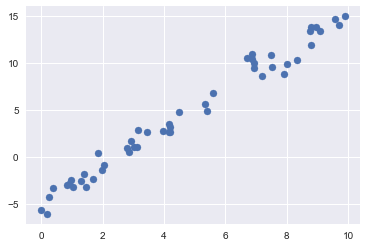

In [3]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2*x - 5 + rng.randn(50)
plt.scatter(x, y);

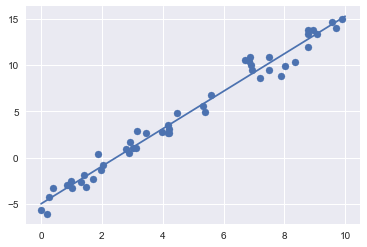

In [6]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 100)
yfit = model.predict(xfit[:,np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)

In [9]:
print ("Model slope:    ", model.coef_[0])
print ("Model intercept:    ", model.intercept_)

('Model slope:    ', 2.0272088103606953)
('Model intercept:    ', -4.9985770855532037)


In [10]:
rng = np.random.RandomState(1)
X = 10*rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2, 1.])

model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.5
[ 1.5 -2.   1. ]


In [12]:
from sklearn.preprocessing import PolynomialFeatures

x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[  2.,   4.,   8.],
       [  3.,   9.,  27.],
       [  4.,  16.,  64.]])

In [13]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7), LinearRegression())

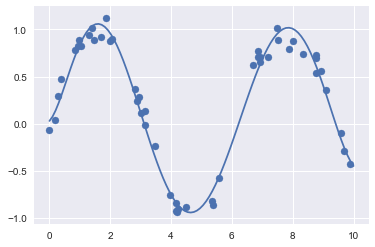

In [14]:
rng = np.random.RandomState(1)
x = 10*rng.rand(50)
y = np.sin(x) + 0.1*rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)

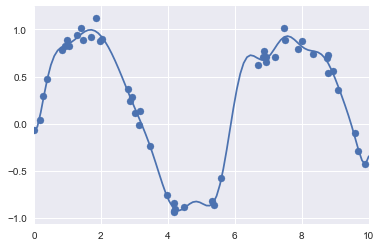

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                    self.width_, axis=1)
gauss_model = make_pipeline(GaussianFeatures(20), LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])
plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

(-1.5, 1.5)

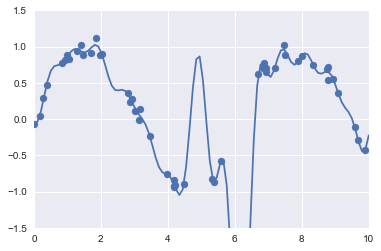

In [24]:
model = make_pipeline(GaussianFeatures(30), LinearRegression())
model.fit(x[:,np.newaxis], y)
plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5)

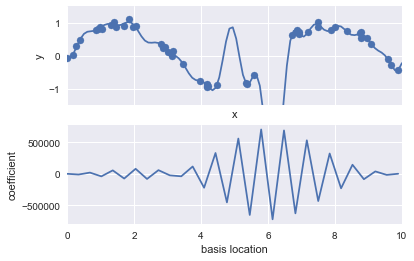

In [25]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    if title:
        ax[0].set_title(title)
    ax[1].plot(model.steps[0][1].centers_,
    model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
    ylabel='coefficient',
    xlim=(0, 10))
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

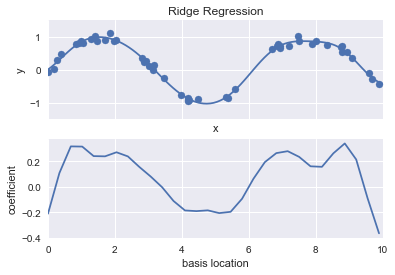

In [26]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


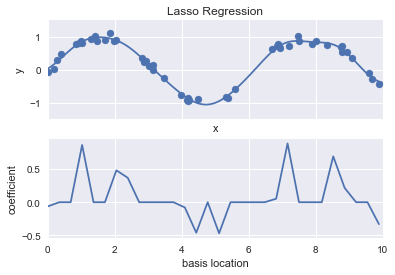

In [27]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression')

In [84]:
import pandas as pd
counts = pd.read_csv('/Users/fedebehrens/Downloads/Fremont_Bridge_Hourly_Bicycle_Counts_by_Month_October_2012_to_present.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('/Users/fedebehrens/Downloads/BicycleWeather.csv', index_col='DATE', parse_dates=True)

In [85]:
daily = counts.resample('d', how='sum')
daily['total'] = daily.sum(axis=1)
daily = daily[['total']]

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.


In [86]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [87]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

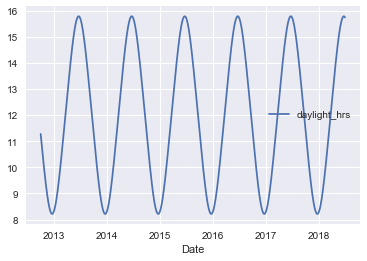

In [88]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
    * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.
daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot();

In [89]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])
# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)
daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

In [90]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [94]:
daily.head()

,total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959


In [100]:
column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names].fillna(0)
y = daily['total']
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

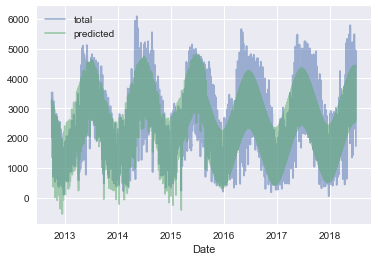

In [101]:
daily[['total', 'predicted']].plot(alpha=0.5);

In [102]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon             -375.938551
Tue             -191.543570
Wed             -214.688388
Thu             -387.364500
Fri             -685.343791
Sat            -2048.071862
Sun            -2105.362341
holiday        -1093.701055
daylight_hrs     260.306065
PRCP            -743.198137
dry day          401.141641
Temp (C)          11.512397
annual            91.377158
dtype: float64

In [104]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_ for i in range(1000)], 0)

In [105]:
print(pd.DataFrame({'effect': params.round(0),
'error': err.round(0)}))

              effect  error
Mon           -376.0   74.0
Tue           -192.0   73.0
Wed           -215.0   71.0
Thu           -387.0   72.0
Fri           -685.0   73.0
Sat          -2048.0   68.0
Sun          -2105.0   70.0
holiday      -1094.0  153.0
daylight_hrs   260.0    7.0
PRCP          -743.0   68.0
dry day        401.0   36.0
Temp (C)        12.0    3.0
annual          91.0   12.0
